# Dominik Adamczyk
## Laboratorium 6 - rozwiązania 

In [92]:
import string, random, time
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

1. Przyjmij następujący zbiór danych wejściowych:
    - bbb$
    - aabbabd
    - ababcd
    - abaababaabaabaabab$
    - losowy tekst o długości 100 znaków,
    - załączony plik.

In [71]:
data = ["bbb$", "aabbabd", "ababcd", "abaababaabaabaabab$"]
data.append("".join(random.choice(string.ascii_letters) for _ in range(100)) + "$")
with open("1997_714_head.txt", "r") as f:
    data.append(f.read())
print(data)

['bbb$', 'aabbabd', 'ababcd', 'abaababaabaabaabab$', 'wsCdRwWigzwrhbNyqINAqgHeaKcafkfEDqDRHQOcfDMcEcCQGPIZLYMkoHGiLBAABFRttywLKqYFcCVdZzVWFiLCPUveqLrzdrWD$', '\n\n\n\nDz.U. z 1998 r. Nr 144, poz. 930\n                                       \n                                       \n                                       \n                                       \n                                    USTAWA\n                          z dnia 20 listopada 1998 r.\n                                       \n         o zryczałtowanym podatku dochodowym od niektórych przychodów\n                        osiąganych przez osoby fizyczne\n                                       \n                                  Rozdział 1\n                                Przepisy ogólne\n                                       \n                                    Art. 1.\nUstawa reguluje opodatkowanie zryczałtowanym podatkiem dochodowym niektórych\nprzychodów (dochodów) osiąganych przez osoby fizyczne prowadzące po

2. Upewnij się, że każdy łańcuch na końcu posiada unikalny znak (marker), a jeśli go nie ma, to dodaj ten zna

Za unikalny znak przyjmuję symbol "$".

In [72]:
def add_unique_marker(data):
    for i, text in enumerate(data):
        if text[-1] != "$":
            data[i] += "$"

add_unique_marker(data)
for i, text in enumerate(data):
    print(f"Data[{i}][-5:]: {text[-5:]}")

Data[0][-5:]: bbb$
Data[1][-5:]: babd$
Data[2][-5:]: abcd$
Data[3][-5:]: abab$
Data[4][-5:]: drWD$
Data[5][-5:]: ym".$


3. Zaimplementuj algorytm konstruujący strukturę trie, która przechowuje wszystkie sufiksy łańcucha danego na wejściu.


In [73]:
class TrieNode: # structure for both - normal construction and suffix link construction
    def __init__(self, char, depth):
        self.depth = depth
        self.char = char
        self.children = {}
        self.link = None
    
    def add_child(self, char):
        if char not in self.children:
            self.children[char] = TrieNode(char, self.depth + 1)
        return self.children[char]
    
    def add_link(self, node):
        self.link = node
        
    def graft(self, suffix):
        node = self
        for char in suffix:
            node = node.add_child(char)
    
    def find(self, suffix):
        node = self
        for char in suffix:
            if char not in node.children:
                return node
            node = node.children[char]
        return node
    
    def find_word(self, _, word):
        curr = self
        for letter in word:
            if letter not in curr.children:
                return False
            curr = curr.children[letter]
        return True
    
    def visualize(self, title = "", links=False):
        def _add_nodes(G, node):
            G.add_node(node)
            for child in node.children.values():
                _add_nodes(G, child)

        def _add_edges(G, node):
            for child in node.children.values():
                G.add_edge(node, child, color='black')
                _add_edges(G, child)

        def _add_suffix_links(G, node, pos):
            if node.link is not None:
                G.add_edge(node, node.link, style = "dashed", color='red')
            for child in node.children.values():
                _add_suffix_links(G, child, pos)
    
        G = nx.DiGraph()
        _add_nodes(G, self)
        _add_edges(G, self)

        pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
        labels = {node: node.char for node in G.nodes()}
        if links:
            _add_suffix_links(G, self, pos)
        e_col = [G[t[0]][t[1]]["color"] for t in G.edges]
        nx.draw_networkx(G, pos=pos, labels=labels, with_labels=True, node_shape='o', edge_color = e_col)
        plt.title(title)
        plt.show()

* Trie - w wariancie, w którym kolejne sufiksy dodawane są przez przeszukiwanie głowy od korzenia drzewa (1p.),

In [74]:
def build_trie(text):
    def initial_trie(text):
        root = TrieNode("", 0)
        root.graft(text)
        return root
    
    root = initial_trie(text)
    for i in range(1, len(text)):
        suffix = text[i:]
        head = root.find(suffix)
        suffix_end = suffix[head.depth:]
        head.graft(suffix_end)
    return root

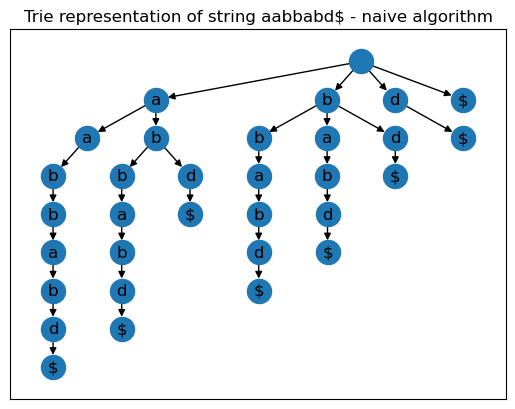

In [75]:
text = data[1]
standard_trie = build_trie(text) 
standard_trie.visualize(title=f"Trie representation of string {text} - naive algorithm")

* Trie - w wariancie, w którym kolejne sufiksy dodawane są poprzez dodanie kolejnej litery tekstu (1p.)

In [76]:
def build_trie_with_suffix_links(text):
    root = TrieNode("", 0)
    deepest = root
    
    for i in range(len(text)):
        a = text[i]
        node = deepest
        deepest = None
        prev = None
        while (node and (a not in node.children)):
            child = node.add_child(a)
            if(not deepest):
                deepest = child
            if(prev):
                prev.add_link(child)
            if(node == root):
                child.add_link(root)
            prev = child
            node = node.link
        if (node):
            prev.add_link(node.children[a])
    return root

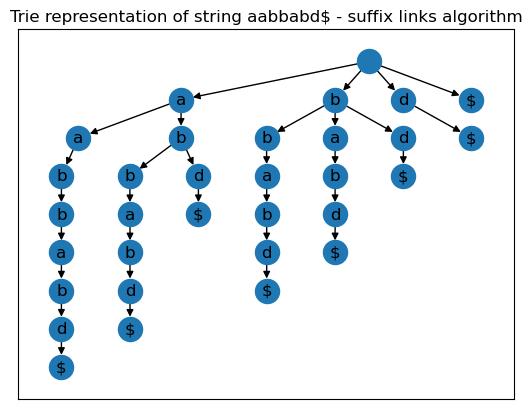

In [77]:
suffix_links_trie = build_trie_with_suffix_links(text)
suffix_links_trie.visualize(title=f"Trie representation of string {text} - suffix links algorithm")

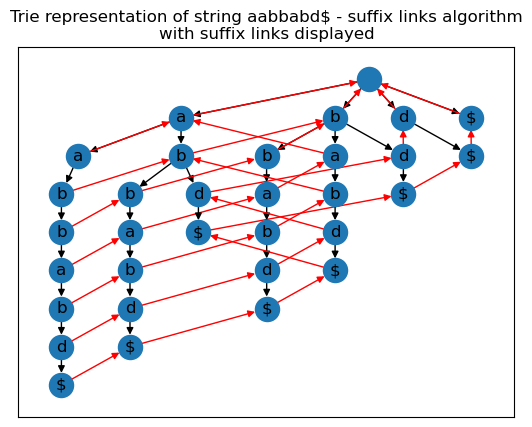

In [78]:
suffix_links_trie.visualize(title=f"Trie representation of string {text} - suffix links algorithm\n" +
                            "with suffix links displayed", links=True)

4. Zaimplementuj algorytm konstruujący drzewo sufiksów.
* Drzewo sufiksów - algorytm Ukkonena (3p).


In [79]:
class SuffixTreeNode:
    def __init__(self, start=0, length=float("inf"), link=None):
        self.start = start
        self.length = length
        self.link = link
        self.children = defaultdict(bool)

    def add_link(self, next):
        self.link = next
        return  next
    
    def visualize(self, title = "", text=""):
        def _add_nodes(G, node):
            G.add_node(node)
            for child in node.children.values():
                _add_nodes(G, child)

        def _add_edges(G, node):
            for child in node.children.values():
                G.add_edge(node, child, color='black')
                _add_edges(G, child)

        def _add_suffix_links(G, node, pos):
            if node.link is not None:
                G.add_edge(node, node.link, style = "dashed", color='red')
            for child in node.children.values():
                _add_suffix_links(G, child, pos)
    
        G = nx.DiGraph()
        _add_nodes(G, self)
        _add_edges(G, self)

        pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
        labels = {node:  (text[node.start: node.start + node.length] if node.length < len(text)
                        else text[node.start: ]) for node in G.nodes()}
        e_col = [G[t[0]][t[1]]["color"] for t in G.edges]
        nx.draw_networkx(G, pos=pos, labels=labels, with_labels=True, node_shape='o', edge_color = e_col)
        plt.title(title)
        plt.show()

    def find_word(self, text, word):
        node = self
        i = 0
        while i < len(word):
            if word[i] not in node.children.keys():
                return False
            node = node.children[word[i]]
            j = node.start
            while j < node.length and i < len(word):
                if text[j] != word[i]:
                    return False
                i += 1
                j += 1
        
        return True

In [80]:
class ActivePoint:
    def __init__(self, root, text):
        self.root = root
        self.node = root
        self.text = text
        self.length = 0
        self.edge = 0
        self.remainder = 0
        
    def update_point(self, node):
        l = node.length
        if self.length >= l:
            self.node = node
            self.edge += l
            self.length -= l
            return True
        return False
    
    def go_with_the_suffix(self):
        self.remainder -= 1
        if self.length > 0 and self.node == self.root:
            self.length -= 1
            self.edge += 1
        else:
            self.node = self.node.link

    def add_new_node(self, child, letter, pos):
        new_node = SuffixTreeNode(child.start, self.length)
        self.node.children[self.text[self.edge]] = new_node
        new_node.children[letter] = SuffixTreeNode(pos)
        child.start += self.length
        child.length -= self.length
        new_node.children[self.text[child.start]] = child
        return new_node

    def on_path(self, child, letter):
        return self.text[child.start + self.length] == letter

def build_suffix_tree(text): # ukkonen algorithm
    root = SuffixTreeNode(0, 0)
    root.link = root
    point = ActivePoint(root, text)

    for (i, letter) in enumerate(text):

        prev = None
        point.remainder += 1

        while point.remainder > 0:

            if not point.length:
                point.edge = i
            
            child = point.node.children[text[point.edge]]
            if child:

                if point.update_point(child):
                    continue

                if point.on_path(child, letter):
                    point.length += 1
                    if prev != None:
                        prev.link = point.node
                    break

                if prev != None:
                    prev.link = point.node

                prev = point.add_new_node(child, letter, i)

            else:
                point.node.children[text[point.edge]] = SuffixTreeNode(i)
                if prev != None:
                    prev.link = point.node
                prev = point.node

            point.go_with_the_suffix()
    return root


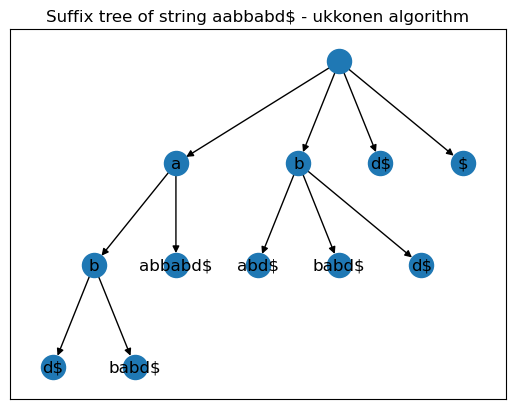

In [81]:
suffix_tree = build_suffix_tree(text)
suffix_tree.visualize(title=f"Suffix tree of string {text} - ukkonen algorithm", text=text)

5. Upewnij się, że powstałe struktury danych są poprawne. Możesz np. sprawdzić, czy struktura zawiera jakiś ciąg znaków i porównać wyniki z algorytmem wyszukiwania wzorców.

Algorytm KMP do sprawdzania, czy dany podciąg istnieje w tekście

In [82]:
def prefix_function(pattern):
    pi = [0]
    k = 0
    for q in range(1, len(pattern)):
        while (k > 0 and pattern[k] != pattern[q]):
            k = pi[k-1]
        if pattern[k] == pattern[q]:
            k = k+1
        pi.append(k)
    return pi

def kmp_string_matching(text, pattern, pi=None):
    if pi is None:
        pi = prefix_function(pattern)
    q = 0
    results = []
    for i in range(0, len(text)):
        while q > 0 and pattern[q] != text[i]:
            q = pi[q-1]
        if q < len(pattern) and pattern[q] == text[i]:
            q = q + 1
        if q == len(pattern):
            results.append(i - q + 1)
            q = pi[q-1]
    return results != []

Funkcje sprawdzająca poprawność algorytmów - sprawdzane jest czy po skonstruowaniu drzewa możliwe jest znalezienie wzorca, funkcją wzorcową jest algorytm KMP

In [87]:
def compare_with_KMP(func, data, title=""):
    print(f"Test of {title} method")
    for (k, text) in enumerate(data):
        i = random.randint(0, len(text) // 2)
        j = random.randint(i, len(text))
        tree = func(text)
        correct_pattern = data[i:j]
        incorrect_pattern = correct_pattern[::-1]
        print(f"\ttest {k}\n\t Correct   pattern test: " + "passed" 
              if tree.find_word(text, correct_pattern) == kmp_string_matching(text, correct_pattern) else "error")
        print("\t Incorrect pattern test: " + "passed"
              if tree.find_word(text, incorrect_pattern) == kmp_string_matching(text, incorrect_pattern) else "error")
    print("\n")

def compare_all():
    compare_with_KMP(build_trie, data, title="standard trie")
    compare_with_KMP(build_trie_with_suffix_links, data, title = "trie with suffix links")
    compare_with_KMP(build_suffix_tree, data, title="suffix tree - ukkonen algorithm")

Testy korzystają ze zbiorów danych wejściowych dostarczonych na początku zadania.

Prawidłowy wzorzec jest generowany jako losowy wycinek wnętrza tekstu.

Potencjalnie nieprawidłowy wzorzec jest odwróceniem prawidłowego wzorca.


In [88]:
compare_all()

Test of standard trie method
	test 0
	 Correct   pattern test: passed
	 Incorrect pattern test: passed
	test 1
	 Correct   pattern test: passed
	 Incorrect pattern test: passed
	test 2
	 Correct   pattern test: passed
	 Incorrect pattern test: passed
	test 3
	 Correct   pattern test: passed
	 Incorrect pattern test: passed
	test 4
	 Correct   pattern test: passed
	 Incorrect pattern test: passed
	test 5
	 Correct   pattern test: passed
	 Incorrect pattern test: passed


Test of trie with suffix links method
	test 0
	 Correct   pattern test: passed
	 Incorrect pattern test: passed
	test 1
	 Correct   pattern test: passed
	 Incorrect pattern test: passed
	test 2
	 Correct   pattern test: passed
	 Incorrect pattern test: passed
	test 3
	 Correct   pattern test: passed
	 Incorrect pattern test: passed
	test 4
	 Correct   pattern test: passed
	 Incorrect pattern test: passed
	test 5
	 Correct   pattern test: passed
	 Incorrect pattern test: passed


Test of suffix tree - ukkonen algorithm m

Testy nie wykazują błędów w implementacji algorytmów tworzenia drzew.

W każdym z przypadków (nie)znalezienie odpowiedniego wzorca daje taki sam efekt co algorytm KMP

6. Porównaj szybkość działania algorytmów konstruujących struktury danych dla danych z p. 1 w następujących wariantach

In [117]:
def compare_time(data=data):
    trie_times = []
    trie_suffix_times = []
    ukkonen_times = []
    sizes = []
    for i, text in enumerate(data):
        t = time.time()
        build_trie(text)
        trie_times.append(time.time() - t)
        t = time.time()
        build_trie_with_suffix_links(text)
        trie_suffix_times.append(time.time() - t)
        t = time.time()
        build_suffix_tree(text)
        ukkonen_times.append(time.time() - t)
        sizes.append(len(text))
        print(f"Test {i:}\nText length: {sizes[-1]}")
        print(f"Standart Trie          {trie_times[-1]} s\nTrie with suffix links {trie_suffix_times[-1]} s\nSuffix tree (Ukkonen)  {ukkonen_times[-1]} s\n\n")
    return trie_times, trie_suffix_times, ukkonen_times, sizes
_ = compare_time()


Test 0
Text length: 4
Standart Trie          0.0 s
Trie with suffix links 0.0 s
Suffix tree (Ukkonen)  0.0 s


Test 1
Text length: 8
Standart Trie          0.0 s
Trie with suffix links 0.0 s
Suffix tree (Ukkonen)  0.0 s


Test 2
Text length: 7
Standart Trie          0.0 s
Trie with suffix links 0.0 s
Suffix tree (Ukkonen)  0.0 s


Test 3
Text length: 19
Standart Trie          0.0 s
Trie with suffix links 0.0 s
Suffix tree (Ukkonen)  0.0 s


Test 4
Text length: 101
Standart Trie          0.12711811065673828 s
Trie with suffix links 0.0060062408447265625 s
Suffix tree (Ukkonen)  0.0 s


Test 5
Text length: 2481
Standart Trie          6.690898895263672 s
Trie with suffix links 9.714734554290771 s
Suffix tree (Ukkonen)  0.002998828887939453 s




Własne dane testowe - losowe ciągi znaków o rosnących długościach

In [126]:
customized_data = []
for i in range (400, 4400, 400):
    customized_data.append("".join(random.choice(string.ascii_letters) for _ in range(i-1)) + "$")


In [127]:
times = compare_time(customized_data)

Test 0
Text length: 400
Standart Trie          0.09799623489379883 s
Trie with suffix links 0.072998046875 s
Suffix tree (Ukkonen)  0.0010001659393310547 s


Test 1
Text length: 800
Standart Trie          3.573521614074707 s
Trie with suffix links 1.48820161819458 s
Suffix tree (Ukkonen)  0.002937793731689453 s


Test 2
Text length: 1200
Standart Trie          2.442656993865967 s
Trie with suffix links 3.094170331954956 s
Suffix tree (Ukkonen)  0.002981424331665039 s


Test 3
Text length: 1600
Standart Trie          4.463178396224976 s
Trie with suffix links 4.208990573883057 s
Suffix tree (Ukkonen)  0.004960536956787109 s


Test 4
Text length: 2000
Standart Trie          6.412279367446899 s
Trie with suffix links 6.3583433628082275 s
Suffix tree (Ukkonen)  0.005000114440917969 s


Test 5
Text length: 2400
Standart Trie          9.4122314453125 s
Trie with suffix links 9.192291021347046 s
Suffix tree (Ukkonen)  0.008075237274169922 s


Test 6
Text length: 2800
Standart Trie          12

<function matplotlib.pyplot.show(close=None, block=None)>

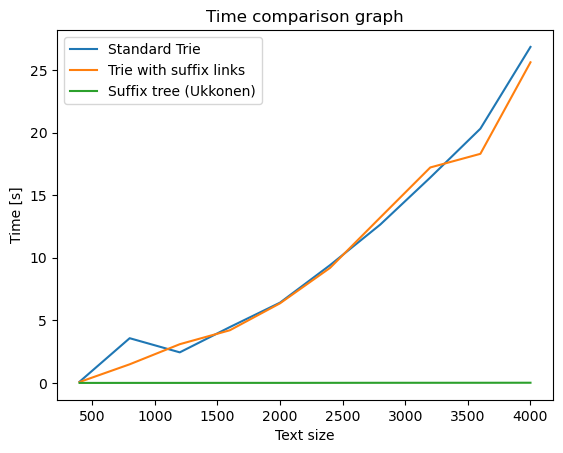

In [128]:
plt.plot(times[-1], times[0], label="Standard Trie")
plt.plot(times[-1], times[1], label="Trie with suffix links")
plt.plot(times[-1], times[2], label="Suffix tree (Ukkonen)")

plt.xlabel("Text size")
plt.ylabel("Time [s]")
plt.title("Time comparison graph")
plt.legend()
plt.show

Wykres obrazuje kwadratową złożoność pierwszych dwóch algorytmów

Czas tworzenia drzewa sufiksów algorytmem Ukkonena dla tekstu długości 1000000 znaków

In [130]:
a = "".join(random.choice(string.ascii_letters) for _ in range(1000000)) + "$"
t = time.time()
build_suffix_tree(a)
print(time.time() - t)

11.142744064331055


Jest to około 10 sekund, podczas gdy algorytmy kwadratowe tworzące drzewo Trie potrzebują tyle czasu dla tekstów mających 2500 znaków.

Pomiędzy algorytmem Ukkonena, a algorytmami kwadratowymi tworzącymi drzewa Trie różnica w czasie jest bardzo zauważalna, tak istotna różnica nie występuje pomiędzy dwoma metodami konstrukcji drzew Trie.